# Compiling GluonCV object detection model using Sagemaker Neo

## Contents

1. [Introduction](#Introduction)
2. [Download Model](#Download-Model)
3. [Create Sagemaker Session](#Create-Sagemaker-Session)
4. [Create MXNet model class](#Create-MXNet-model-class)
5. [Compile model](#Compile-model) 


### Introduction

In this example, we familiarize with compilation of a MXNet model using Sagemaker Neo. [GluonCV](https://gluon-cv.mxnet.io/) provides state of art algorithms for object detection. MXNet fast and flexible framework supported with different language bindings. MXNet is easy to use and Gluon library provides high level interface such that training, deployment and compilation is easier with Sagemaker.
For more information, refer : [MXNet Introduction](https://mxnet.apache.org/)

Object detection models identifies the positions and classes of objects in an image. Here is a sample prediction from an object detection model(Image from http://cocodataset.org/#home).

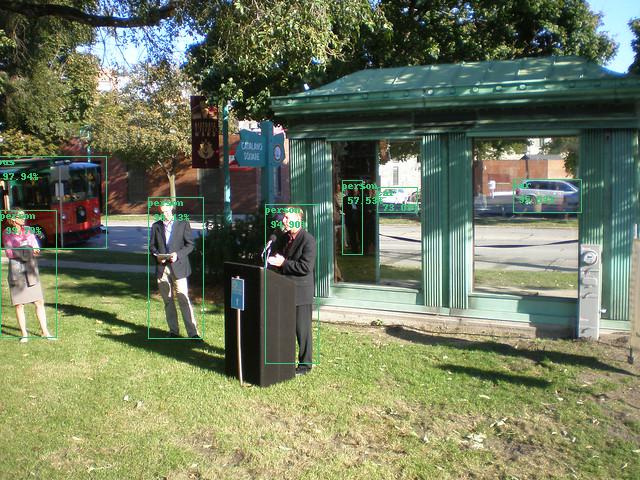

In MXNet, an object detection model predicts objects, bounding boxes enclosing objects, classes and confidence values. 

In this example we compile a SSD-Mobilenet model for Jetson Nano. Also we can familiarize with _Model Class_ in Sagemaker Python SDK.

__For basic familairity, please refer,__
* [Sagemaker Python SDK](https://sagemaker.readthedocs.io/en/stable/)
* [GluonCV Object Detection](https://gluon-cv.mxnet.io/build/examples_detection/index.html)
* [Sagemaker Model](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html)

### Person detection model

This example converts an SSD MobilenetV1 model to detect persons in an image.

SSD-MobilenetV1.0 uses ([SSD](https://arxiv.org/abs/1512.02325)) algorithm for object detection and ([Mobilenet V1](https://arxiv.org/pdf/1704.04861.pdf)) for feature map. 

The input image size for this model is [1,3,512,512].

MXNet models are defined using a combination of _.json_ and _.params_ files. Here we have _.json_ and _.params_ files for person detection model. The model is obtained by reusing weights from a pretrained modelin GluonCV. The python file _reuse-model.py_ contains code to generate the model. Certain object detection models can be downloaded from [GluonCV Model Zoo](https://gluon-cv.mxnet.io/api/model_zoo.html). For neo compilation, we need compressed file with format _.tar.gz_. Compress files before compilation.  

In [ ]:
!pip3 install gluoncv

In [ ]:
# untar file
!tar xvf person-detection.tar.gz

In [ ]:
classes = ['Person']
with open('classes.lst','w') as f:
    for c in classes:
        f.write(c)
        f.write('\n')
f.close()

In [ ]:
 # import the gluoncv modules for prediction
import mxnet as mx
from gluoncv.utils import download, viz
from mxnet import gluon
import PIL
from gluoncv.utils import viz
from mxnet import nd
from mxnet.io import ImageRecordIter
import matplotlib.pyplot as plt
import gluoncv as gcv

### Optional

Test the model in the notebook instance

In [ ]:
# Load model
net =gluon.SymbolBlock.imports('person-detection-symbol.json',['data'],'person-detection-0000.params')
net.hybridize(static_alloc=True, static_shape=True)
ctx = [mx.gpu() if mx.context.num_gpus() > 0 else mx.cpu()] 
net(mx.nd.ones((1,3,512,512), ctx=ctx[0]))

In [ ]:

# predict the results
classes = ['Person']
image_files = ['28c19c63766eaf52.jpg'] # (Image from Open Images Dataset - https://storage.googleapis.com/openimages/web/index.html)

for i in image_files:
    x, image = gcv.data.transforms.presets.ssd.load_test(i, 512)
    cid, score, bbox = net(x)

    ax = viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=classes)
    plt.show()

### Create sagemaker session

Import the python sagemaker module. We need access to AWS Services. We use the IAM role of the notebook instance for Sagemaker and S3 access. Here we will use the execution role the current notebook instance was given when it was created. IAM role should be selected such that it has access to necessary AWS services.

Set the default bucket, if need an existing bucket.

Once the model is uploaded to S3 bucket, we can see the file from S3 bucket console. The foolowing code print the S3 bucket path.

Enter your default S3 bucket instead of _< your default bucket name>_

In [ ]:
import sagemaker
from sagemaker import get_execution_role

role= get_execution_role()

session = sagemaker.Session(default_bucket='<your default bucket name>')
bucket = session.default_bucket()
print('Default bucket =' + bucket)

model_name = 'person-detection.tar.gz'
# upload the model to the folder in  bucket
prefix = 'person-detection'
model_path = session.upload_data(path=model_name, key_prefix= prefix)

# prints the path to the compressed model
print('S3 file path ' +model_path)

### Create MXNet model class

Create a [MXNet Model()](https://sagemaker.readthedocs.io/en/stable/frameworks/mxnet/sagemaker.mxnet.html#mxnet-model) using sagemaker. Model class enables deployment of a model. The entry point graph is empty, since we are performing a compilation job for Jetson Nano without any pre or postprocessing. Here, the pre- and post-processing are performed on the edge device.

In [ ]:
from sagemaker.mxnet import MXNetModel
from sagemaker.predictor import RealTimePredictor

# compile a model using Model class in sagemaker
model = MXNetModel(model_data=model_path,
              role= role,
              sagemaker_session = session,
              framework_version='1.5.1',
              entry_point='entry_point.py',
              py_version='py3',
             predictor_cls = RealTimePredictor)

__Compilation of a MXNet model__

Next we compile the compressed model using Sagemaker Neo.

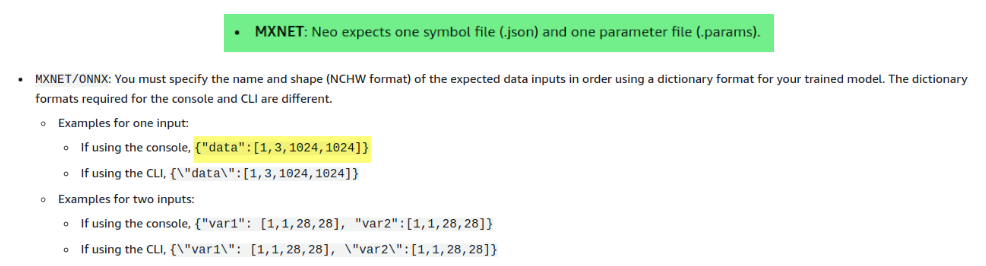

Refer [Neo Troubleshooting](https://docs.aws.amazon.com/sagemaker/latest/dg/neo-troubleshooting.html).

Set the parameters for compilation job. The S3 bucket path to compressed model file, name for compilation job, input data shape, target device for which model has to be tuned, frameowrk of model, output path.

In [ ]:
from sagemaker.utils import name_from_base

compilation_job_name = name_from_base('person-detection')
# input shape to the model
data_shape = '{"data":[1,3,512,512]}'
# edge device name
target_device = 'jetson_nano'
# framework of pretrained model
framework = 'MXNET'

output_prefix = '{}/output/{}'.format(prefix,compilation_job_name)
compiled_model_path = 's3://{}/{}'.format(bucket,output_prefix)

### Compile model

Once the compilation job parameters are set, we can compile the model using **compile** function the Model class. Neo tunes the model to obtain a better performance on target device. the current compilation jobs can be viewed from __Amazon Sagemaker -> Compilation jobs__ console.

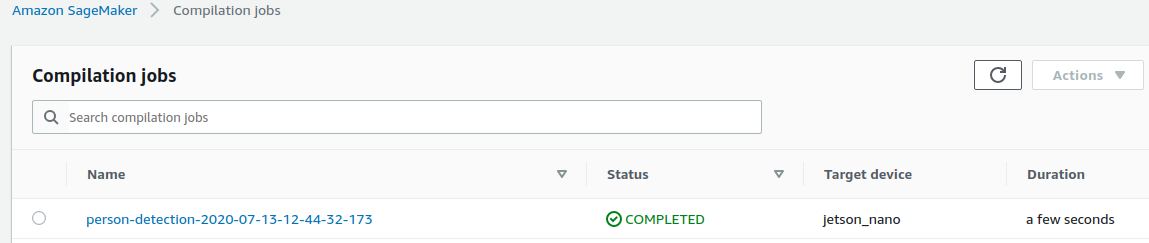

In [ ]:
compiled_model = model.compile(target_instance_family=target_device, 
                               input_shape=data_shape,
                               job_name=compilation_job_name,
                               role=role,
                               framework=framework,
                               output_path=compiled_model_path
                               )

Since compiled model has to be tested on Jetson Nano, download the model from S3 bucket. Either we can download the model here and transfer to Jetson Nano. To download the model to the notebook instance, run the following code.



In [ ]:
model_name = '{}-{}.tar.gz'.format('person-detection', target_device)
file = '{}/{}'.format(output_prefix,model_name)

path =session.download_data('./',bucket, key_prefix=file)

### Upload model with class list to destination bucket

Add class list to the final model.

In [ ]:
!mkdir compiled_model
!mv classes.lst compiled_model/

In [ ]:
command = 'tar xvf '+model_name+' -C compiled_model'
os.system(command)

In [ ]:
new_model_name = 'person-detection-model.tar.gz'
command = 'tar -C compiled_model -czvf ' + new_model_name + ' .'
os.system(command)

In [ ]:
!rm -r compiled_model/

In [ ]:
# upload model to the destination bucket
prefix = 'jetson_nano_models'
model_path = session.upload_data(path=new_model_name, key_prefix= prefix)

# prints the path to the compressed model
print('S3 file path ' +model_path)